In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.
c:\users\kleck\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\kleck\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\kleck\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
img_height = 512
img_width = 512
n_classes = 1

K.clear_session()

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], #scales originalni pro SSD
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.185,
               iou_threshold=0.5,
               #confidence_thresh=0.2,
               #iou_threshold=0.2,
               top_k=200,
               nms_max_output_size=400)



#nacteni modelu
weights_path = 'load_models/ssd512_person_detection.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #adam optimaizer

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


In [3]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'img/myImg_11.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)


Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  1.     0.91 183.6  202.52 211.11 323.03]
 [  1.     0.2  450.18 221.74 461.94 269.68]]


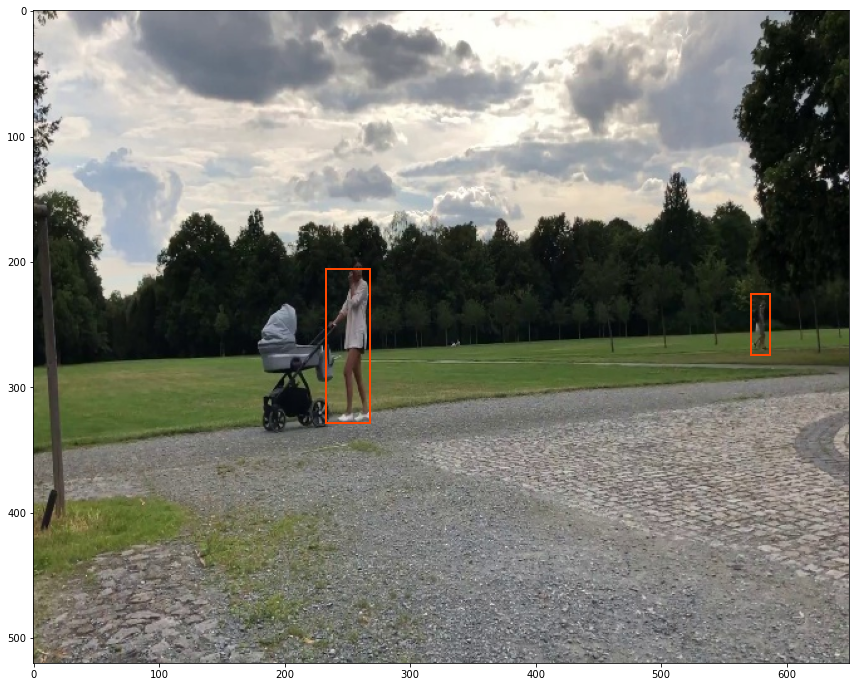

In [4]:
y_pred = model.predict(input_images)
confidence_threshold = 0.185

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])





colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['Person']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Prevedeni ohraniceni na originalni obrazek
    xmin = box[-4] * orig_images[0].shape[1] /img_width
    ymin = box[-3] * orig_images[0].shape[0] /img_height
    xmax = box[-2] * orig_images[0].shape[1] /img_width
    ymax = box[-1] * orig_images[0].shape[0] /img_height
    color = colors[int(box[0])]
    label = 'Person'
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  


fig = current_axis.get_figure()
fig.savefig('test_img/ssd_test.jpg')

